In [35]:
import pickle
import numpy as np
import os
from tqdm import tqdm
import json
import keras

#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam


from PIL import Image
import matplotlib.pyplot as plt

In [36]:
# load features form pickle
with open(os.path.join(os.getcwd(), 'features2.pkl'), "rb") as f:
  features = pickle.load(f)

# load features form pickle
with open(os.path.join(os.getcwd(), 'tokenizer2.pkl'), "rb") as f:
  tokenizer = pickle.load(f)
print(len(tokenizer.word_index) + 1)


# Opening JSON file
with open('meta_data_mobilenet.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
 
print(json_object)
print(type(json_object))
max_length, vocab_size = json_object['max_length'], json_object['vocab_size']
print(max_length, vocab_size)

8494
{'vocab_size': 8485, 'max_length': 34}
<class 'dict'>
34 8485


In [42]:
#load Model
model_cnn = MobileNet(weights='imagenet')

# change Archi
model_cnn = Model(model_cnn.input, model_cnn.layers[-2].output)

# model summary
# model_cnn.summary()

# change Archi
# encoder model
# image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
#se1 = Word2Vec(all_captions, 256, min_count=1)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = LSTM(256)(se3)

# decoder model
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt)

# Load the model
model.load_weights('./model_mobilenet.h5')

In [43]:
print(model)

In [44]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

def generate_caption(image_name, model, directory = os.path.join(os.getcwd(), 'Flicker8k_Dataset')):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq she is she in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in


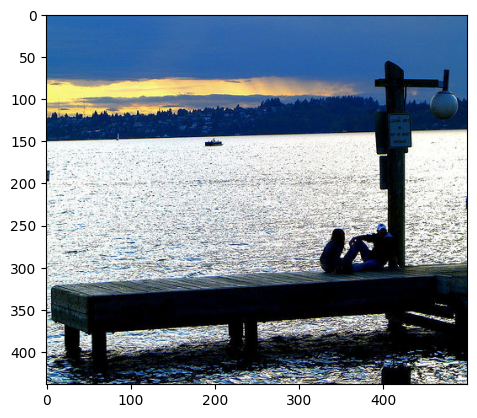

In [45]:
directory = os.path.join(os.getcwd(), 'Flicker8k_Dataset')
#generate_caption("1001773457_577c3a7d70.jpg", model)
generate_caption("42637986_135a9786a6.jpg", model)